In [10]:
from maps.screens import ImageScreen
import json

# Set path to parameter file
param_file = "/home/kkumbier/als/scripts/maps/template_analyses/params/qc.json"

# Marker set for which figures will be generated
marker_set = "FUS/EEA1"

PALETTE = {
    "WT": "#9A9A9A",
    "FUS": "#B24745" ,
    "C9orf72": "#6A6599",
    "sporadic": "#79AF97",
    "SOD1": "#00A1D5",
    "TDP43": "#DF8F44"
}


# Overview
The `maps` pipeline is an analytical toolbox for molecular phenotyping. The core data structures are `Screen`s. These classes serve as a container to load and store data / metadata associated with a screen. Data processing/modeling steps are applied to `Screen`s. `Screen`s are defined relative to a set of parameters, specified in through a python `dict`. As a result, analytical parameters can be easily stored as json files to ensure reproducibility of workflows. 

Below, we load in a parameter file for exploratory data analysis. You can see several keys that reference aspects of where data for the screen are located (`screen`, `root`, `data_file`, and `eval_dir`). Additional keys reference data processing steps (`preprocessing`) and analyses (`analysis`) to be performed. We initialize an `ImageScreen` class based on these parameters—additional `Screen` types (e.g., for proteomics, transcriptomics, etc.) are forthcoming.

In [11]:
# Load in analysis parameters
with open(param_file) as f:
    params = json.load(f)
 
print(json.dumps(params, indent=4))

# Initialize screen class and run data processing pipeline 
screen = ImageScreen(params)
print(screen.loader.list_antibodies())

screen.load(antibody=marker_set)
screen.preprocess()

{
    "name": "quality_control",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ]
                }
            ]
        },
        "select_feature_types": {
            "feature_str": "^.*Intensity.*$|^.*Spot.*$"
        },
        "drop_feature_types": {
            "feature_str": "^.*Sum$"
        },
        "drop_constant_features": {}
    }
}
shape: (9,)
Series: 'Antibody' [str]
[
	"TDP43_abcam/G3BP1"
	"p62/LC3"
	"HSP70/SOD1"
	"CD63/SEC16A"
	"pTDP43/HMOX1"
	"Rab1/CHMP2B"
	"FUS/EEA1"
	"COX IV/Galectin3/atubulin"
	"LAMP/TDP43-C"
]


## Quality control
Figures below report cell counts and distribution of intensity features over the plate. 

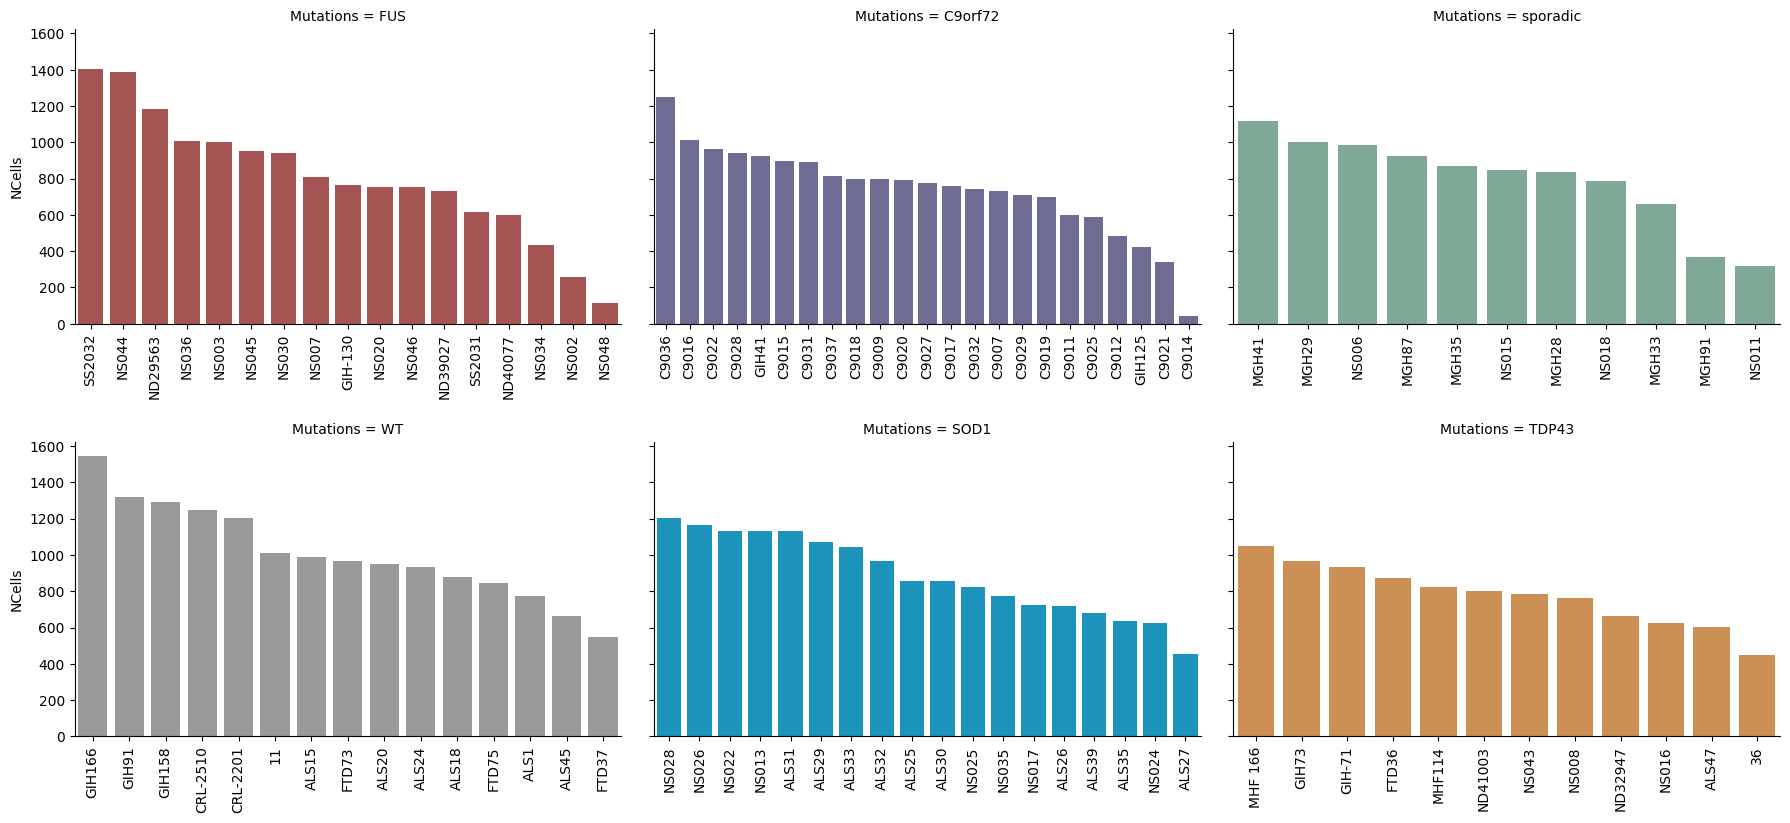

In [12]:
from maps.figures import plot_cell_count   

fig = plot_cell_count(
    screen, 
    facets="Mutations", 
    sharey=True, # share scale on y-axis
    sharex=False, # set x-axis as distinct 
    col_wrap=3,
    aspect=1.5,
    height=4
)

fig.show()

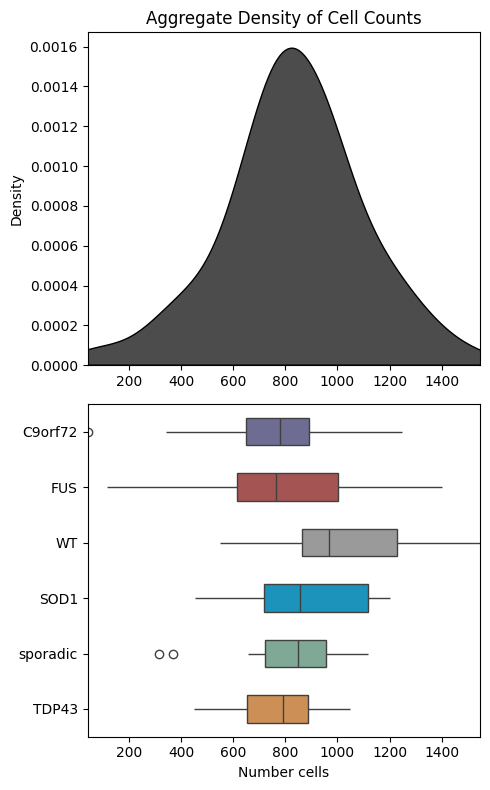

In [13]:
from maps.figures import boxplot_cell_counts
fig = boxplot_cell_counts(screen, hue="Mutations", palette=PALETTE)
fig.set_size_inches(5, 8)
fig.tight_layout()
fig.show()

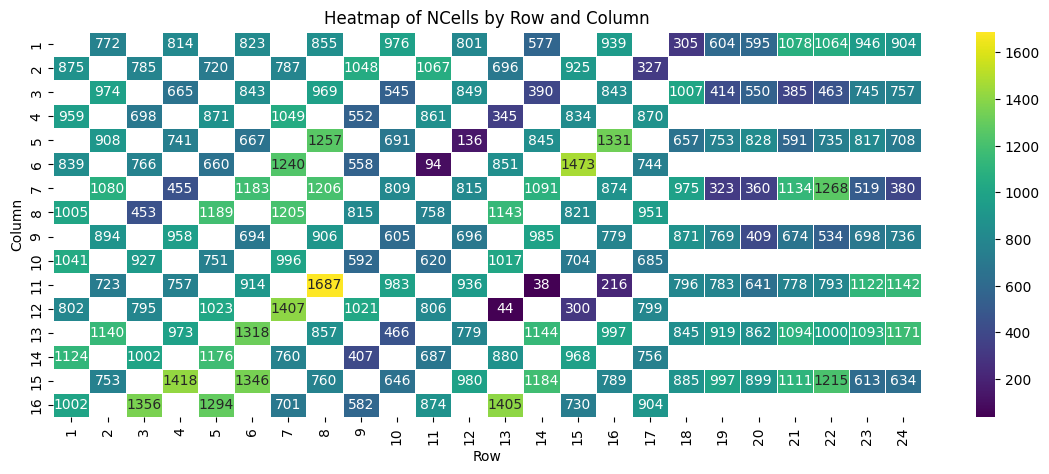

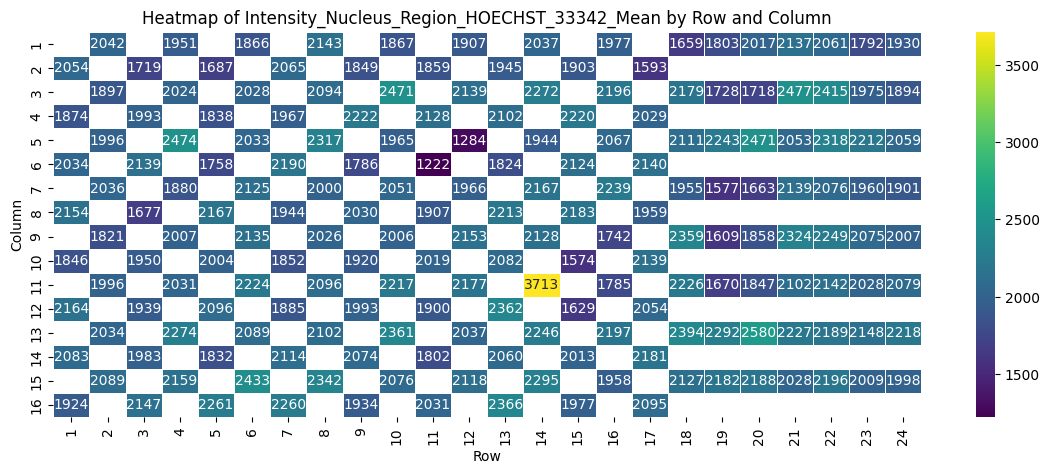

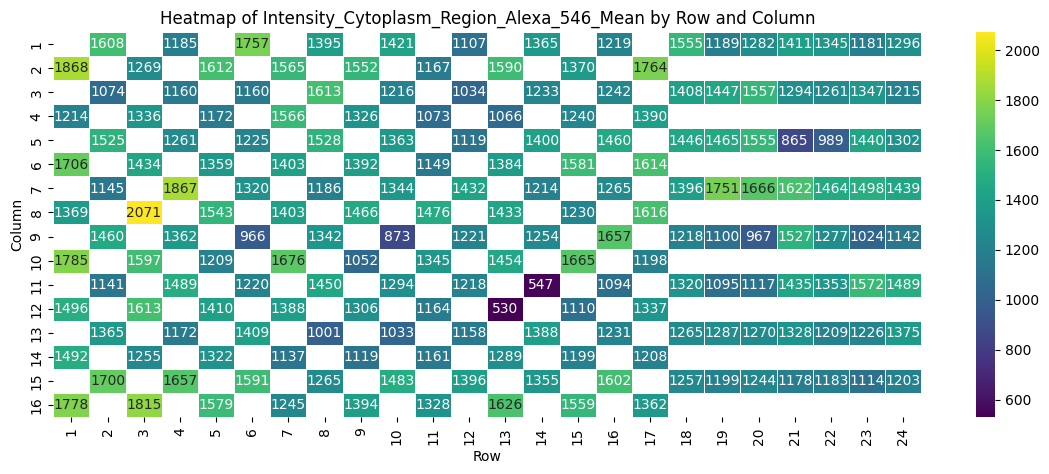

In [14]:
from maps.figures import plot_plate

fig = plot_plate(screen, "NCells")
fig.set_size_inches(14, 5)
fig.show()

fig = plot_plate(screen, "Intensity_Nucleus_Region_HOECHST_33342_Mean")
fig.set_size_inches(14, 5)
fig.show()

fig = plot_plate(screen, "Intensity_Cytoplasm_Region_Alexa_546_Mean")
fig.set_size_inches(14, 5)
fig.show()

## PCA projection
A PCA module is included under `maps.analyses`. PCA projections below are computed on the full marker set. Note that in general, we drop many of the features before running the maps analysis. To drop segmentation markers, you can adjust the `preprocessing.drop_feature_types` key in your params.json file. E.g., the example below matches "Sum", "HOECHST", and "546" (segmentation marker) features and drops them from the dataset. The params can also be adjusted programatically, which we do below to compare PCA with and without certain features.

```
params = {
    ...,
    "preprocessing": {
        ...,
       "drop_feature_types": {
        "feature_str": "^.*Sum$|^.*HOECHST.*$|^.*546.*$"
       },
       ...
    },
    ...
}
```

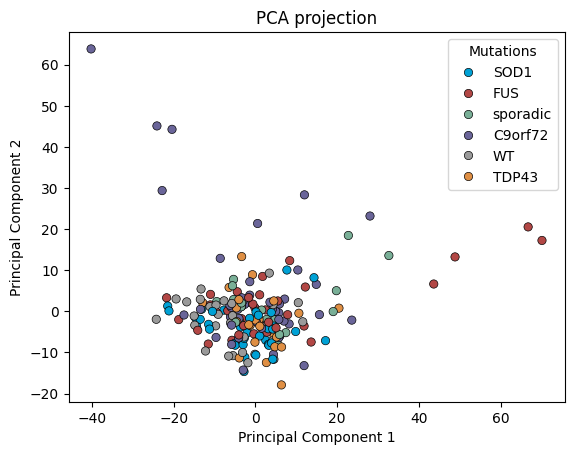

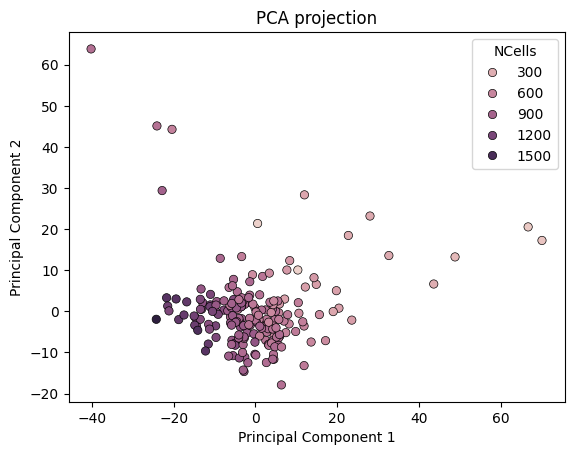

In [15]:
from maps.analyses import PCA
from maps.figures import plot_pca

pca = PCA(screen)
pca.fit()

fig = plot_pca(pca, hue="Mutations", palette=PALETTE)
fig.show()

fig = plot_pca(pca, hue="NCells")
fig.show()

# Adjusted preprocessing
QC plots above reveal a few outlier cell lines. We can programitically adjust our screen to by running additional preprocessing steps. This could also be achieved by adding arguments to the we adjust the preprocessing parameters to (i) drop these cell lines and (ii) analyze non-segmentation markers.

In [16]:
from maps.processing import drop_feature_types, drop_sample_by_feature

screen = drop_feature_types(
    screen, feature_str="^.*Sum$|^.*HOECHST.*$|^.*546.*$"
)

screen = drop_sample_by_feature(
    screen, drop_key=[{"CellLines": ["C9014", "NS048"]}]
)

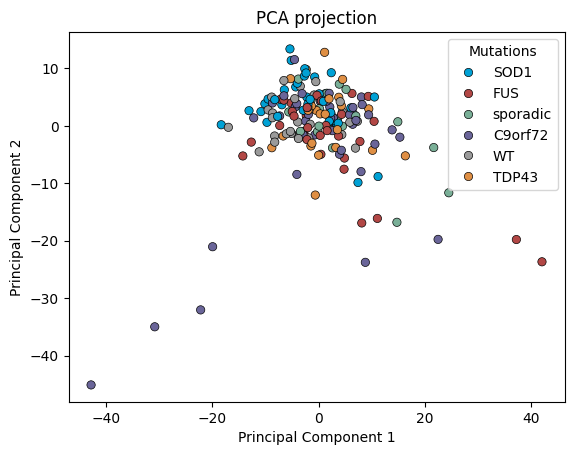

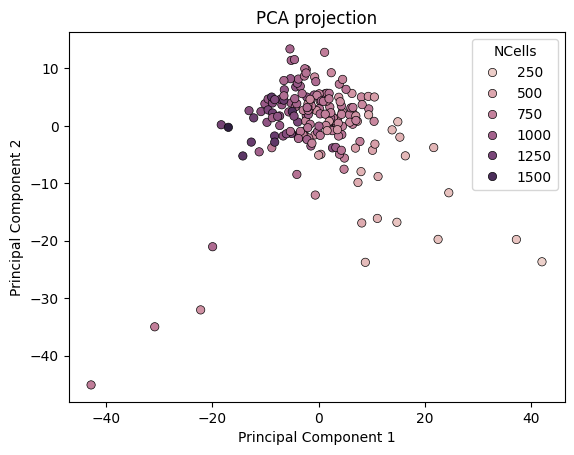

In [17]:
pca = PCA(screen)
pca.fit()

fig = plot_pca(pca, hue="Mutations", palette=PALETTE)
fig.show()

fig = plot_pca(pca, hue="NCells")
fig.show()